# [Ateliers: Technologies de l'intelligence Artificielle](https://github.com/wikistat/AI-Frameworks)

<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" width=400, style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# Introduction to Reinforcement Learning 
 
Source : [https://github.com/ageron/handson-ml](https://github.com/ageron/handson-ml)


https://github.com/breeko/Simple-Reinforcement-Learning-with-Tensorflow/blob/master/Part%202%20-%20Policy-based%20Agents%20with%20Keras.ipynb

# AI Gym Librairie
<a href="https://gym.openai.com/" ><img src="https://gym.openai.com/assets/dist/home/header/home-icon-54c30e2345.svg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with.

## Import librairies

In [1]:
import numpy as np
import random
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib inline
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.initializers as ki
import tensorflow.keras.optimizers as ko
import tensorflow.keras.losses as klo
import tensorflow.keras.backend as K


# Gym Librairy
import gym

def display_environment(env):
    img = env.render(mode="rgb_array")
    env.close()
    plt.figure(figsize=(5,4))
    plt.imshow(img)
    plt.axis("off")

## Gym Environment 

Next we will load the MsPacman environment, version 0.

In [2]:
env = gym.make('MsPacman-v0')

Let's initialize the environment by calling is `reset()` method. This returns an observation:

In [3]:
obs = env.reset()

Observations vary depending on the environment. In this case it is an RGB image represented as a 3D NumPy array of shape [width, height, channels] (with 3 channels: Red, Green and Blue). In other got environments it may return different objects, as we will see later.

In [5]:
obs.shape

(210, 160, 3)

An environment can be visualized by calling its `render()` method, and you can pick the rendering mode (the rendering options depend on the environment). In this example we will set `mode="rgb_array"` to get an image of the environment as a NumPy array:

In [6]:
img = env.render(mode="rgb_array")

Let's plot this image:

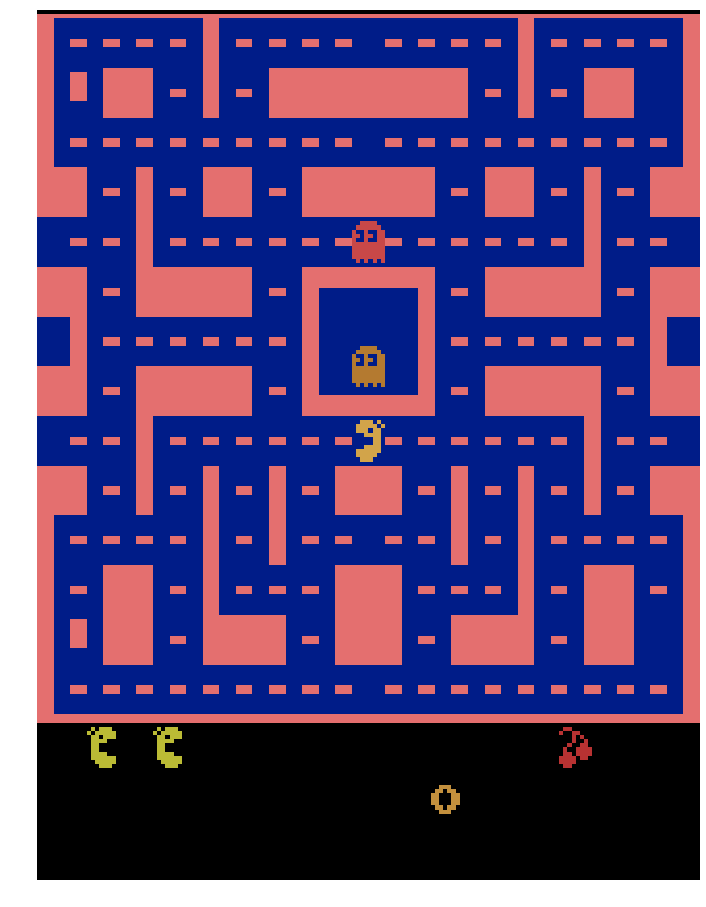

In [7]:
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.axis("off")
plt.savefig("pacman",dpi=200, bbox_inches="tight")
plt.show()


Welcome back to the 1980s! :)

In this environment, the rendered image is simply equal to the observation (but in many environments this is not the case):

In [8]:
(img == obs).all()

True

Let's create a little helper function to plot an environment:

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [9]:
env.action_space

Discrete(9)

`Discrete(9)` means that the possible actions are integers 0 through 8, which represents the 9 possible positions of the joystick (0=center, 1=up, 2=right, 3=left, 4=down, 5=upper-right, 6=upper-left, 7=lower-right, 8=lower-left).

Next we need to tell the environment which action to play, and it will compute the next step of the game. Let's go left for 110 steps, then lower left for 40 steps:

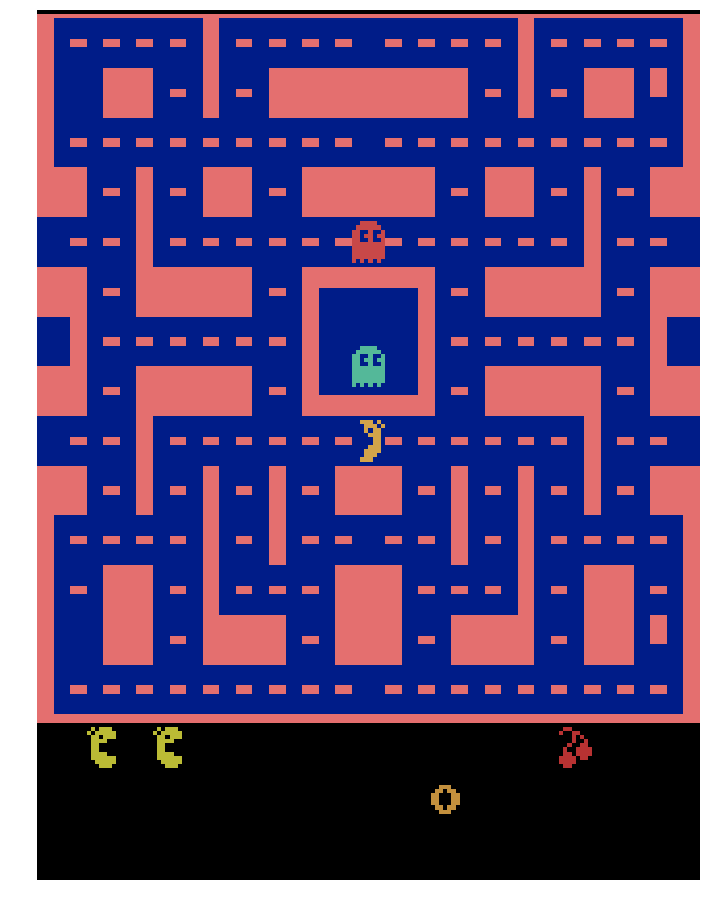

In [10]:
#env.reset()
for step in range(1):
    env.step(2)
img = env.render(mode="rgb_array")
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.axis("off")
plt.savefig("pacman_3",dpi=200, bbox_inches="tight")
#plt.show()

Where are we now?

The `step()` function actually returns several important objects:

In [11]:
obs, reward, done, info = env.step(0)

The observation tells the agent what the environment looks like, as discussed earlier. This is a 210x160 RGB image:

In [12]:
obs.shape

(210, 160, 3)

The environment also tells the agent how much reward it got during the last step:

In [13]:
reward

0.0

When the game is over, the environment returns `done=True`:

In [14]:
done

False

Finally, `info` is an environment-specific dictionary that can provide some extra information about the internal state of the environment. This is useful for debugging, but your agent should not use this information for learning (it would be cheating).

In [15]:
info

{'ale.lives': 3}

Let's play one full game (with 3 lives), by moving in random directions for 10 steps at a time, recording each frame:

In [17]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample() # play randomly
    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation (it's a bit jittery within Jupyter):

In [18]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

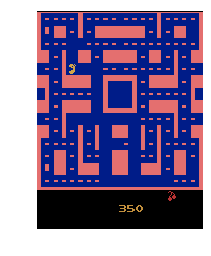

In [18]:
HTML(plot_animation(frames).to_html5_video())


Once you have finished playing with an environment, you should close it to free up resources:

In [19]:
env.close()

To code our first learning agent, we will be using a simpler environment: the Cart-Pole. 

# A simple environment: the Cart-Pole

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [19]:
env = gym.make("CartPole-v0")

In [20]:
obs = env.reset()
obs

array([-0.01237703,  0.011636  ,  0.04299444,  0.00779701])

(-0.5, 1199.5, 799.5, -0.5)

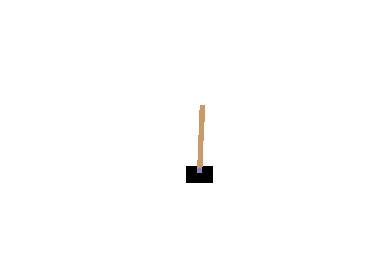

In [21]:
img = env.render(mode = "rgb_array")
env.close()
plt.imshow(img)
plt.axis("off")

The observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

In [22]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left or towards the right. Let's push the cart left until the pole falls:

In [23]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

(-0.5, 1199.5, 799.5, -0.5)

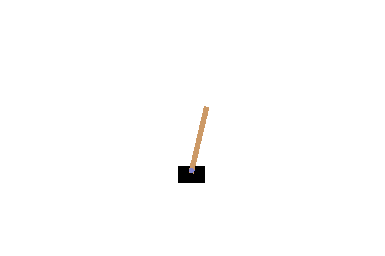

In [24]:
img = env.render(mode = "rgb_array")
env.close()
plt.imshow(img)
plt.axis("off")

In [25]:
img.shape

(800, 1200, 3)

Notice that the game is over when the pole tilts too much, not when it actually falls. Now let's reset the environment and push the cart to right instead:

In [26]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

(-0.5, 1199.5, 799.5, -0.5)

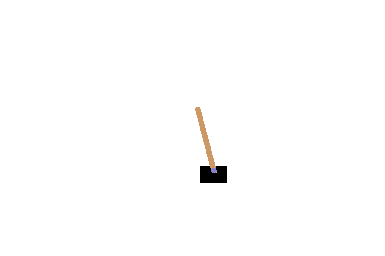

In [27]:
img = env.render(mode = "rgb_array")
env.close()
plt.imshow(img)
plt.axis("off")


Looks like it's doing what we're telling it to do. Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

In [28]:
# Try running environment with random actions
env.reset()
reward_sum = 0
num_games = 10
num_game = 0
while num_game < num_games:
#     env.render()
    observation, reward, done, _ = env.step(env.action_space.sample())
    reward_sum += reward
    if done:
        print("Reward for this episode was: {}".format(reward_sum))
        reward_sum = 0
        num_game += 1
        env.reset()

Reward for this episode was: 32.0
Reward for this episode was: 27.0
Reward for this episode was: 12.0
Reward for this episode was: 43.0
Reward for this episode was: 29.0
Reward for this episode was: 13.0
Reward for this episode was: 20.0
Reward for this episode was: 18.0
Reward for this episode was: 27.0
Reward for this episode was: 19.0


# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [29]:
# Try running environment with random actions
reward_sum = 0
num_games = 10
num_game = 0
n_step_before_fail = 0
obs = env.reset()
reward
while num_game < num_games:
    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1
    reward_sum += reward
    if done:
        print("Reward for this episode was: {} ({} step)".format(reward_sum, n_step_before_fail))
        reward_sum = 0
        num_game += 1
        n_step_before_fail=0
        env.reset()
        
    

Reward for this episode was: 40.0 (40 step)
Reward for this episode was: 27.0 (27 step)
Reward for this episode was: 43.0 (43 step)
Reward for this episode was: 44.0 (44 step)
Reward for this episode was: 43.0 (43 step)
Reward for this episode was: 46.0 (46 step)
Reward for this episode was: 62.0 (62 step)
Reward for this episode was: 37.0 (37 step)
Reward for this episode was: 47.0 (47 step)
Reward for this episode was: 43.0 (43 step)


In [30]:
frames = []

n_max_steps = 1000
n_change_steps = 10
n_step_before_fail = 0
obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode = "rgb_array")
    env.close()
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1
    n_step_before_fail +=1
    obs, reward, done, info = env.step(action)
    if done:
        break
n_step_before_fail

49

In [31]:
img.shape

(800, 1200, 3)

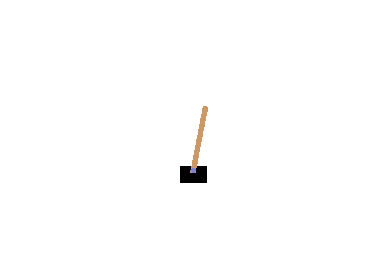

In [32]:
HTML(plot_animation(frames).to_html5_video())

Nope, the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the action to take for each observation. To choose an action, the network will first estimate a probability for each action, then select an action randomly according to the estimated probabilities. In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

Note: instead of using the `fully_connected()` function from the `tensorflow.contrib.layers` module (as in the book), we now use the `dense()` function from the `tf.layers` module, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same.

The main differences relevant to this chapter are:
* the `_fn` suffix was removed in all the parameters that had it (for example the `activation_fn` parameter was renamed to `activation`).
* the `weights` parameter was renamed to `kernel`,
* the default activation is `None` instead of `tf.nn.relu`

In [33]:


# 1. Specify the network architecture
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 4  # it's a simple task, we don't need more than this
n_outputs = 1 # only outputs the probability of accelerating left
initializer = ki.VarianceScaling()

# 2. Build the neural network
policy_network=km.Sequential()
policy_network.add(kl.Dense(n_hidden, input_shape = (n_inputs,), activation = "relu", kernel_initializer = initializer))
policy_network.add(kl.Dense(n_outputs, activation = "sigmoid", kernel_initializer = initializer))

policy_network.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [34]:
obs = env.reset()
# Generate the probability of action 0
p_left = policy_network.predict(np.expand_dims(obs,axis=0))
# Choose and action according to the previously generated probability
action = 0 if random.uniform(0,1)< p_left else 1 

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we are picking a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

In [35]:
# Try running environment with random actions
reward_sum = 0
num_games = 10
num_game = 0
n_step_before_fail
obs = env.reset()
reward
while num_game < num_games:
    # hard-coded policy
    p_left = policy_network.predict(np.expand_dims(obs,axis=0))
    action = 0 if random.uniform(0,1)< p_left else 1 
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1
    reward_sum += reward
    if done:
        print("Reward for this episode was: {} ({} step)".format(reward_sum, n_step_before_fail))
        reward_sum = 0
        num_game += 1
        n_step_before_fail=0
        env.reset()

Reward for this episode was: 22.0 (71 step)
Reward for this episode was: 13.0 (13 step)
Reward for this episode was: 40.0 (40 step)
Reward for this episode was: 18.0 (18 step)
Reward for this episode was: 14.0 (14 step)
Reward for this episode was: 18.0 (18 step)
Reward for this episode was: 13.0 (13 step)
Reward for this episode was: 11.0 (11 step)
Reward for this episode was: 14.0 (14 step)
Reward for this episode was: 13.0 (13 step)


Let's randomly initialize this policy neural network and use it to play one game:

In [36]:
n_max_steps = 1000
frames = []

n_step_before_fail = 0

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode = "rgb_array")
    env.close()
    frames.append(img)
    p_left = policy_network.predict(np.expand_dims(obs,axis=0))
    action = 0 if random.uniform(0,1)< p_left else 1 
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1

    if done:
        break

env.close()
n_step_before_fail


14

Now let's look at how well this randomly initialized policy network performed:

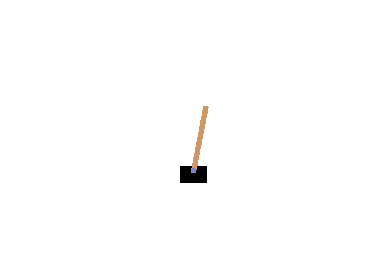

In [37]:
plt.close()
HTML(plot_animation(frames).to_html5_video())

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right. The following code defines the same neural network but we add the target probabilities `y`, and the training operations (`cross_entropy`,  `optimizer` and `training_op`):

In [38]:
learning_rate = 0.01


policy_network=km.Sequential()
policy_network.add(kl.Dense(n_hidden, input_shape = (n_inputs,), activation = "relu", kernel_initializer = initializer))
policy_network.add(kl.Dense(n_outputs, activation = "sigmoid", kernel_initializer = initializer))

# apprentissage
adam = ko.Adam(lr = learning_rate)
policy_network.compile(loss='binary_crossentropy',optimizer=ko.Adam(lr = learning_rate),metrics=['accuracy'])


We can make the same net play in 10 different environments in parallel, and train for 1000 iterations. We also reset environments when they are done.

In [39]:
n_environments = 10
n_iterations = 2000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = np.array([env.reset() for env in envs])


for iteration in range(n_iterations):
    target_probas = np.array([(1 if obs[2] < 0 else 0) for obs in observations]) # if angle<0 we want proba(left)=1., or else proba(left)=0.
    policy_network.train_on_batch(observations, target_probas)  # one batch iteration
    
    # Generate probablity and observation on ntext step
    p_lefts = policy_network.predict(observations)
    actions = [0 if random.uniform(0,1)< p_left else 1 for p_left in p_lefts]
    
    # Compute next state
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

In [40]:
# Try running environment with random actions
reward_sum = 0
num_games = 10
num_game = 0
n_step_before_fail
obs = env.reset()
reward
while num_game < num_games:
    # hard-coded policy
    p_left = policy_network.predict(np.expand_dims(obs,axis=0))
    action = 0 if random.uniform(0,1)< p_left else 1 
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1
    reward_sum += reward
    if done:
        print("Reward for this episode was: {} ({} step)".format(reward_sum, n_step_before_fail))
        reward_sum = 0
        num_game += 1
        n_step_before_fail=0
        env.reset()

Reward for this episode was: 68.0 (82 step)
Reward for this episode was: 38.0 (38 step)
Reward for this episode was: 37.0 (37 step)
Reward for this episode was: 29.0 (29 step)
Reward for this episode was: 39.0 (39 step)
Reward for this episode was: 48.0 (48 step)
Reward for this episode was: 58.0 (58 step)
Reward for this episode was: 39.0 (39 step)
Reward for this episode was: 49.0 (49 step)
Reward for this episode was: 43.0 (43 step)


In [41]:
n_max_steps = 10000
frames = []

n_step_before_fail = 0

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode = "rgb_array")
    env.close()
    frames.append(img)
    p_left = policy_network.predict(np.expand_dims(obs,axis=0))
    action = 0 if random.uniform(0,1)< p_left else 1 
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1

    if done:
        break

env.close()
n_step_before_fail       

65

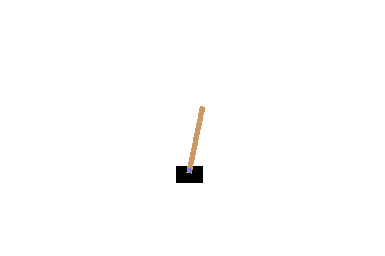

In [42]:
plt.close()
HTML(plot_animation(frames).to_html5_video())

Looks like it learned the policy correctly. Now let's see if it can learn a better policy on its own.

# Policy Gradients

To train this neural network we will need to define the target probabilities `y`. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in a game, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple games, then making the actions in good games slightly more likely, while actions in bad games are made slightly less likely. First we play, then we go back and think about what we did.

Once again define the same neural network architecture

In [43]:
def get_policy_model(env, hidden_layer_neurons, lr):
    dimen = env.reset().shape
    num_actions = 1
    inp = kl.Input(shape=dimen,name="input_x")
    adv = kl.Input(shape=[1], name="advantages")
    x = kl.Dense(hidden_layer_neurons, 
                     activation="relu", 
                     use_bias=False,
                     kernel_initializer=initializer,
                     name="dense_1")(inp)
    out = kl.Dense(num_actions, 
                       activation="sigmoid", 
                       kernel_initializer=initializer,
                       use_bias=False,
                       name="out")(x)

    def my_custom_loss(y_true, y_pred):
       
        log_lik = - (y_true*K.log(y_pred) + (1-y_true)*K.log(1-y_pred))
        return K.mean(log_lik * adv, keepdims=True)
        
    model_train = km.Model(inputs=[inp, adv], outputs=out)
    model_train.compile(loss=my_custom_loss, optimizer=ko.Adam(lr))
    model_predict = km.Model(inputs=[inp], outputs=out)
    return model_train, model_predict

In [44]:
def discount_rewards(r, gamma=0.99):
    """Takes 1d float array of rewards and computes discounted reward
    e.g. f([1, 1, 1], 0.99) -> [2.9701, 1.99, 1]
    """
    prior = 0
    out = []
    for val in r:
        new_val = val + prior * gamma
        out.append(new_val)
        prior = new_val
    return np.array(out[::-1])

In [45]:
# Constants defining our neural network
hidden_layer_neurons = 8
gamma = .99
dimen = len(env.reset())
print_every = 100
batch_size = 50
num_episodes = 10000
render = False
lr = 1e-2
goal = 190

In [46]:
# See our trained bot in action
def score_model(model, num_tests, render=False):
    scores = []    
    for num_test in range(num_tests):
        observation = env.reset()
        reward_sum = 0
        while True:
            if render:
                env.render()

            state = np.reshape(observation, [1, dimen])
            predict = model.predict([state])[0]
            action = 0 if predict>0.5 else 1 
            observation, reward, done, _ = env.step(action)
            reward_sum += reward
            if done:
                break
        scores.append(reward_sum)
    env.close()
    return np.mean(scores)

In [47]:
model_train, model_predict = get_policy_model(env, hidden_layer_neurons, lr)
model_predict.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_x (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 32        
_________________________________________________________________
out (Dense)                  (None, 1)                 8         
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


In [48]:
reward_sum = 0

num_actions = env.action_space.n

# Placeholders for our observations, outputs and rewards
states = np.empty(0).reshape(0,dimen)
actions = np.empty(0).reshape(0,1)
rewards = np.empty(0).reshape(0,1)
discounted_rewards = np.empty(0).reshape(0,1)

# Setting up our environment
observation = env.reset()

num_episode = 0

losses = []

while num_episode < num_episodes:
    # Append the observations to our batch
    state = np.reshape(observation, [1, dimen])
    
    predict = model_predict.predict([state])[0]
    action = 0 if random.uniform(0,1)< predict else 1 
    
    # Append the observations and outputs for learning
    states = np.vstack([states, state])
    actions = np.vstack([actions, action])
    
    # Determine the oucome of our action
    observation, reward, done, _ = env.step(action)
    reward_sum += reward
    rewards = np.vstack([rewards, reward])
    
    if done:
        # Determine standardized rewards
        discounted_rewards_episode = discount_rewards(rewards, gamma)       
        discounted_rewards = np.vstack([discounted_rewards, discounted_rewards_episode])
        
        rewards = np.empty(0).reshape(0,1)

        if (num_episode + 1) % batch_size == 0:
            discounted_rewards -= discounted_rewards.mean()
            discounted_rewards /= discounted_rewards.std()
            discounted_rewards = discounted_rewards.squeeze()
           
        
            actions_train = 1-actions
            #b()
            loss = model_train.train_on_batch([states, discounted_rewards], actions_train)
            losses.append(loss)
            
            # Clear out game variables
            states = np.empty(0).reshape(0,dimen)
            actions = np.empty(0).reshape(0,1)
            discounted_rewards = np.empty(0).reshape(0,1)

            #print(losses)
        # Print periodically
        if (num_episode + 1) % print_every == 0:
            # Print status
            score = score_model(model_predict,10)
            print("Average reward for training episode {}: {:0.2f} Test Score: {:0.2f} Loss: {:0.6f} ".format(
                (num_episode + 1), reward_sum/print_every, 
                score,
                losses[-1]))
            
            if score >= goal:
                print("Solved in {} episodes!".format(num_episode))
                break
            reward_sum = 0
                
        num_episode += 1
        observation = env.reset()
        

Average reward for training episode 100: 21.62 Test Score: 67.40 Loss: -0.002764 
Average reward for training episode 200: 26.12 Test Score: 75.60 Loss: -0.004047 
Average reward for training episode 300: 26.70 Test Score: 111.40 Loss: -0.009539 
Average reward for training episode 400: 30.16 Test Score: 104.10 Loss: -0.009421 
Average reward for training episode 500: 27.06 Test Score: 82.30 Loss: -0.008041 
Average reward for training episode 600: 29.65 Test Score: 113.60 Loss: -0.012793 
Average reward for training episode 700: 29.75 Test Score: 100.40 Loss: -0.012137 
Average reward for training episode 800: 34.80 Test Score: 101.90 Loss: -0.013695 
Average reward for training episode 900: 34.09 Test Score: 125.90 Loss: -0.015956 
Average reward for training episode 1000: 40.48 Test Score: 128.30 Loss: -0.012802 
Average reward for training episode 1100: 38.48 Test Score: 161.90 Loss: -0.018103 
Average reward for training episode 1200: 43.39 Test Score: 171.80 Loss: -0.013254 
Aver

In [50]:
# Try running environment with random actions
reward_sum = 0
num_games = 10
num_game = 0
n_step_before_fail = 0
obs = env.reset()
reward
while num_game < num_games:
    # hard-coded policy
    p_left = model_predict.predict(np.expand_dims(obs,axis=0))
    action = 0 if p_left[0]>0.5 else 1 
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1
    reward_sum += reward
    if done:
        print("Reward for this episode was: {} ({} step)".format(reward_sum, n_step_before_fail))
        reward_sum = 0
        num_game += 1
        n_step_before_fail=0
        env.reset()

Reward for this episode was: 200.0 (200 step)
Reward for this episode was: 200.0 (200 step)
Reward for this episode was: 200.0 (200 step)
Reward for this episode was: 146.0 (146 step)
Reward for this episode was: 200.0 (200 step)
Reward for this episode was: 200.0 (200 step)
Reward for this episode was: 67.0 (67 step)
Reward for this episode was: 59.0 (59 step)
Reward for this episode was: 200.0 (200 step)
Reward for this episode was: 154.0 (154 step)


In [51]:
n_max_steps = 10000
frames = []

n_step_before_fail = 0

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode = "rgb_array")
    env.close()
    frames.append(img)
    p_left = model_predict.predict(np.expand_dims(obs,axis=0))
    action = 0 if p_left[0][0]>0.5 else 1 
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1

    if done:
        break

env.close()
n_step_before_fail 

198

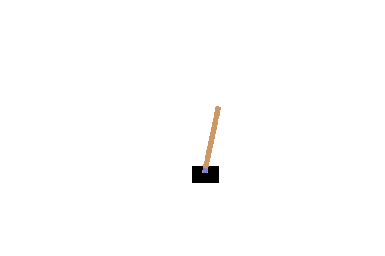

In [52]:
plt.close()
HTML(plot_animation(frames).to_html5_video())